# QRS detection

In [134]:
import matplotlib.pyplot as plt
import numpy             as np
import wfdb

%matplotlib inline

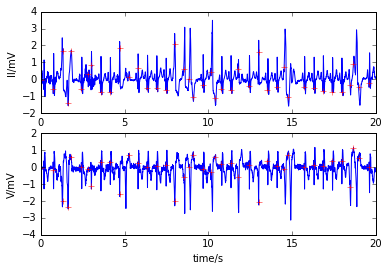

In [133]:
start = 0
end = 5000
end_time = 10
fs = 250
sample_name = 'v532s'
sig, fields = wfdb.rdsamp('sample_data/challenge_training_data/' + sample_name)
sample_annotation = wfdb.rdann('sample_data/challenge_training_ann/' + sample_name, 'gqrs', sampfrom = start, sampto = end)

wfdb.plotwfdb(sig[start:end,:2], fields, annsamp=sample_annotation[0], annch = [0,1])